# Algorithmic Development for Reconstructing Surface Ocean pCO$_2$
## Using SHAP values to evaluate models

This research project focuses on studying feature importance in the ML model that reconstructs surface ocean pCO$_2$. Our main concern was to analyze and validate the physical nature of the model, and identify whether additional data was required to improve it. 
We conduct a SHAP value analysis to validate that trends in the features make physical sense. We also investigate connections between model inaccuracies and their respective features.

Parts 1 and 2 of the code set up the workspace and create the reconstruction with member r1r10 from the CanESM model. 

# Part 1: Setting up workspace

In [ ]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/" # change it to your own project dir

Mounted at /content/drive


In [ ]:
#@title install the packages
!pip install SkillMetrics
!pip install cmocean
!pip3 install cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install shap


     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 149 kB 45.4 MB/s 
     |████████████████████████████████| 223 kB 28.5 MB/s 
     |████████████████████████████████| 10.8 MB 36.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 43.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 51.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 52.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.7 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516286 sha256=c5df41dd210ccca07899653d29dbd71e69b

In [ ]:
#@title import necessary packages
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle
import skill_metrics as sm
import math
import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots
import shap

# machine learning libraries
from sklearn.model_selection import train_test_split

In [ ]:
#@title set current working directory
os.chdir(f"{root_dir}/lib/") 
print(os.getcwd())
#/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib/

/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib


In [ ]:
#@title load user codes
# Python file with supporting functions
import pre
#import decompose as stl
from spatial_map import SpatialMap

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


# Part 2: Create reconstruction (with XGBoost)

In [ ]:
#@title Define reconstruction experiment parameters
# define which ESM you will use, which member of the large ensemble, time range, and directories of the files
ens = 'CanESM2'
member = 'r1r10'

date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2017-01-31T00:00:00.000000000'

dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

data_output_dir = f"{root_dir}/ESM/data/processed"
ensemble_dir_head = f"{root_dir}/ESM/" # Set this to where you have placed the raw data
xco2_path = f"{root_dir}/ESM/CESM001/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc" # xCO2(atmospheric CO2 mole fraction) is the same across members so only reference it once


reference_output_dir = f"{root_dir}/references"
model_output_dir = f"{root_dir}/models/trained"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"

approach = "xgb"
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"


In [ ]:
#@title load and save data
# Uncomment to use new data
# load and save data
df = pre.create_inputs(ensemble_dir_head, ens, member, dates, xco2_path=xco2_path)
pre.save_clean_data(df, data_output_dir, ens, member)

start to import member data
finish importing member data
start to create feature
Starting data saving process
Save complete


In [ ]:
#@title check data
data_dir = f"{data_output_dir}/{ens}/member_{member}"
fname = f"data_clean_2D_mon_{ens}_{member}_1x1_198201-201701.pkl"
file_path = f"{data_dir}/{fname}"

df = pd.read_pickle(file_path)
df=df.reset_index()
df["month"]=pd.DatetimeIndex(df["time"]).month
df["year"]=pd.DatetimeIndex(df["time"]).year
df.head()

,time,xlon,ylat,sss,SST,MLD,Chl,pCO2,socat_mask,mld_log,...,sst_anom,T0,T1,A,B,C,net_mask,xco2,month,year
0,1982-01-15,0.5,-89.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.999962,0.000076,-0.008726,NaN,340.848541,1,1982
1,1982-01-15,0.5,-88.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.999657,0.000228,-0.026176,NaN,340.848541,1,1982
2,1982-01-15,0.5,-87.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.999048,0.000381,-0.043618,NaN,340.848541,1,1982
3,1982-01-15,0.5,-86.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.998135,0.000533,-0.061046,NaN,340.848541,1,1982
4,1982-01-15,0.5,-85.5,0.0,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,0.966848,0.255353,-0.996917,0.000685,-0.078456,NaN,340.848541,1,1982


In [ ]:
#@title set up for model training
# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# =========================================
# Defining some inputs for the modeling process
# =========================================

# Train-validate-test split proportions
val_prop = .2
test_prop = .2

# Parameter grids
xg_param_grid = {"n_estimators":[2000, 3000, 4000],
                 "max_depth":[4,5,6]
                }

# Feature and target lists for feeding into the models
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1',"month","year","xlon","ylat"]
target_sel = ['pCO2']

In [ ]:
#@title data preparation. prepare the seen and unseen data. split the train and test data

data_dir = f"{data_output_dir}/{ens}/member_{member}"
fname = f"data_clean_2D_mon_{ens}_{member}_1x1_198201-201701.pkl"
file_path = f"{data_dir}/{fname}"
        
# Read in data, create some selection filters, produce a reduced dataframe
#df = pd.read_pickle(file_path)

# 816 represents 3 standard deviations above mean in SOCAT data -- observations above this threshold are unrealistic to observe in real-world data
recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()
sel = (recon_sel & (df['socat_mask'] == 1))
unseen_sel = (recon_sel & (df['socat_mask'] == 0))
        
 # Convert dataframe to numpy arrays, train/val/test split
from sklearn.model_selection import train_test_split
X_dev, X_test,y_dev, y_test=train_test_split(df.loc[sel,features_sel],df.loc[sel,target_sel], test_size=test_prop, shuffle=True)
X_train_val, X_val, y_train_val,y_val=train_test_split(X_dev, y_dev, test_size=val_prop/(1-test_prop), shuffle=True)

In [ ]:
#@title Fit the model on train/validation data
features_sel_2 = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
model = XGBRegressor(n_jobs=1)
model.fit(X_train_val[features_sel_2], y_train_val)          

# Save the model
pre.save_model(model, model_output_dir, approach, ens, member)

[19:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Starting model saving process
Save complete


# Part 3: Results (SHAP values)

##Detour
**What are shapley values?**<br>
Shapley values is a concept of cooperative game theory where different players work together (in cooperation) towards a common goal and are awarded payouts inline with their individual contributions. In our case the goal is the prediction for a particular instance, the players are all the feature values of an instance, and the gain is the actual predictions for this instance minus the average predictions for all the instances.

To be put simply, **shapley values indicate how much a feature value contribute to the prediction**

To be more precise, shapley value is the average marginal contribution of a feature value across all possible coalitions

Please refer the following for an in-depth explaination<br>
1. https://christophm.github.io/interpretable-ml-book/shapley.html
2. https://www.youtube.com/watch?v=NBg7YirBTN8&t=11s

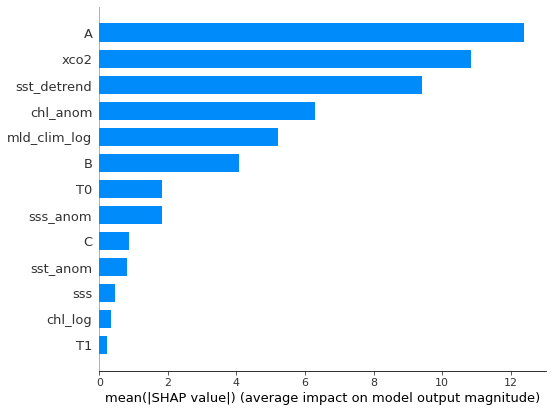

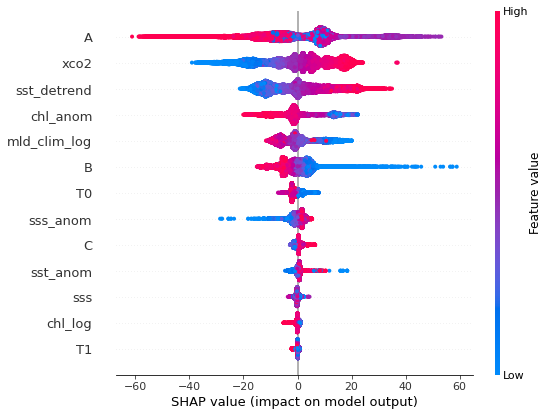

In [ ]:
#@title Display shap values for XGBoost
import shap

shap_values_XGB = shap.TreeExplainer(model).shap_values(X_test[features_sel_2])
top_variables=X_test.columns[np.argsort(np.abs(shap_values_XGB).mean(0))[::-1]]
shap.summary_plot(shap_values_XGB, X_test[features_sel_2], plot_type='bar')
shap.summary_plot(shap_values_XGB, X_test[features_sel_2])

**Feature Importance (figure 1)**: Here we can see that the heaviest feature dependence is on the variable A, which is just a function of latitude. Since latitude doesn't change over time, we will ignore it in our temporal analysis. <br>
**Swarm Plot(figure 2)**: Showcases how exactly the shapley value contribution varies with the feature values. For instance higher values of xCO2 have a positive contribution on the prediction values while lower xCO2 values have a negative contribution on the prediction values   



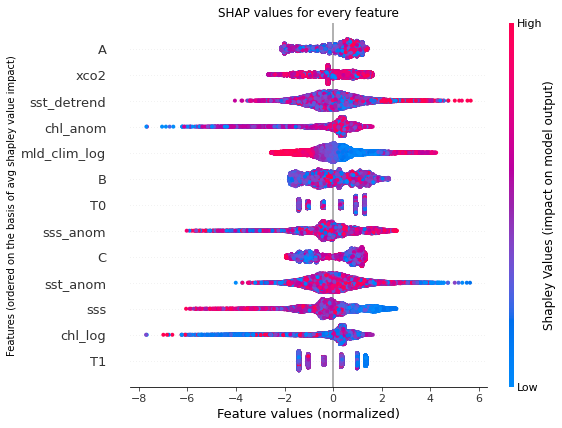

In [ ]:
#@title Modified swarm plot (with swapped axes)
shap_values_XGB = shap.TreeExplainer(model).shap_values(X_test[features_sel_2])

from sklearn.preprocessing import StandardScaler
features_sel_2_sorted=[x for _,x in sorted(zip(list(pd.DataFrame(shap_values_XGB).abs().mean()),features_sel_2))][::-1] # to preserve the order of shap value contribution

shap.summary_plot(StandardScaler().fit_transform(X_test[features_sel_2_sorted].to_numpy()),
                  pd.DataFrame(shap_values_XGB,columns=X_test[features_sel_2_sorted].columns),
                  show=False,color_bar_label='Shapley Values (impact on model output)',
                   sort=False,)

plt.title("SHAP values for every feature")
plt.ylabel("Features (ordered on the basis of avg shapley value impact)")
plt.xlabel("Feature values (normalized)")
plt.show()

The same swarm plot with shapley values and feature values swapped along the axes. It is a little harder to read than the previous chart and hence it was not included in the presentation

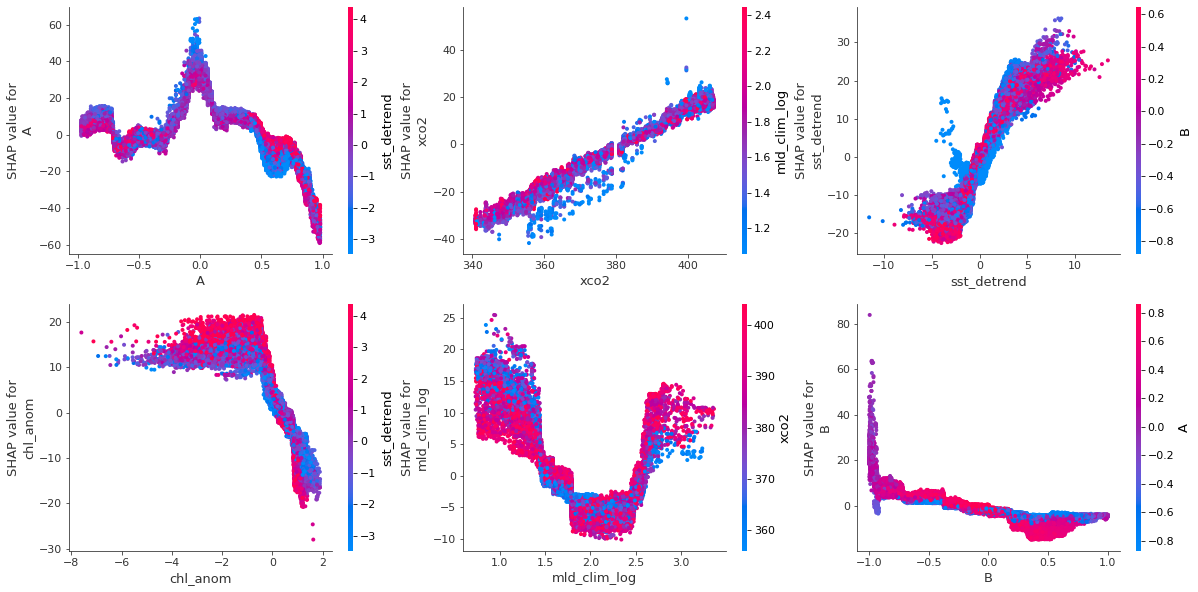

In [ ]:
#@title Dependence Plots
n_top_features=5
# list(top_variables)[0:n_top_features]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# axes = axes.ravel()

#for i in range(n_top_features):
shap.dependence_plot(list(top_variables)[0], shap_values_XGB, X_test[features_sel_2],ax=axes[0,0],show=False)
shap.dependence_plot(list(top_variables)[1], shap_values_XGB, X_test[features_sel_2],ax=axes[0,1],show=False)
shap.dependence_plot(list(top_variables)[2], shap_values_XGB, X_test[features_sel_2],ax=axes[0,2],show=False)
shap.dependence_plot(list(top_variables)[3], shap_values_XGB, X_test[features_sel_2],ax=axes[1,0],show=False)
shap.dependence_plot(list(top_variables)[4], shap_values_XGB, X_test[features_sel_2],ax=axes[1,1],show=False)
shap.dependence_plot(list(top_variables)[5], shap_values_XGB, X_test[features_sel_2],ax=axes[1,2],show=False)
plt.show()

**Interaction plots between the most important features:** These plots show how the shapley value impact of a variable is affected by other variables. Let's look at the 2nd plot (xCO2 vs mld_clim_log) clearly, for instances with lower xCO2 values and lower mld_clim_log(blue)  have lower shapley values as compared to those with lower XCO2 but higher mld_clim_log values. However, this trend reverses for higher xCO2 values.

In [ ]:
#@title Appending time and coordinate columns to SHAP values for analyzing temporal and spatial shapely contribution of features
shap_values_XGB = shap.TreeExplainer(model).shap_values(X_test[features_sel_2]) # Re-running shap value for the sake of rewriting the data that we modified in place earlier to avoid the model from craashing
shap_values_XGB=pd.DataFrame(shap_values_XGB)
shap_values_XGB=shap_values_XGB.set_index(X_test.index)
shap_values_XGB.columns=[features_sel_2]
shap_values_XGB["month"]=X_test["month"]
shap_values_XGB["year"]=X_test["year"]
shap_values_XGB["xlon"]=X_test["xlon"]
shap_values_XGB["ylat"]=X_test["ylat"]
shap_values_XGB.columns = shap_values_XGB.columns.get_level_values(0)
shap_values_XGB.head()

# Assigning ocean basin wrt given the coordinate
def assign_ocean_basin(xlon,ylat):
  """
  Input: Takes in latitute and longitude
  Return: Ocean basin classified into Pacific, Indian Ocean, Atlantic, and Arctic
  """
  if ylat>=-66.5 and ylat<=-30:
    return "South Sub-tropical"
  elif ylat>-30 and ylat<30:
    return "Tropical"
  elif ylat<=66.5 and ylat>=30:
    return "North Sub-tropical"
  else:
    return "Pole area"

shap_values_XGB["Ocean Basin"] = shap_values_XGB.apply(lambda x: assign_ocean_basin(x.xlon, x.ylat), axis=1 )

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


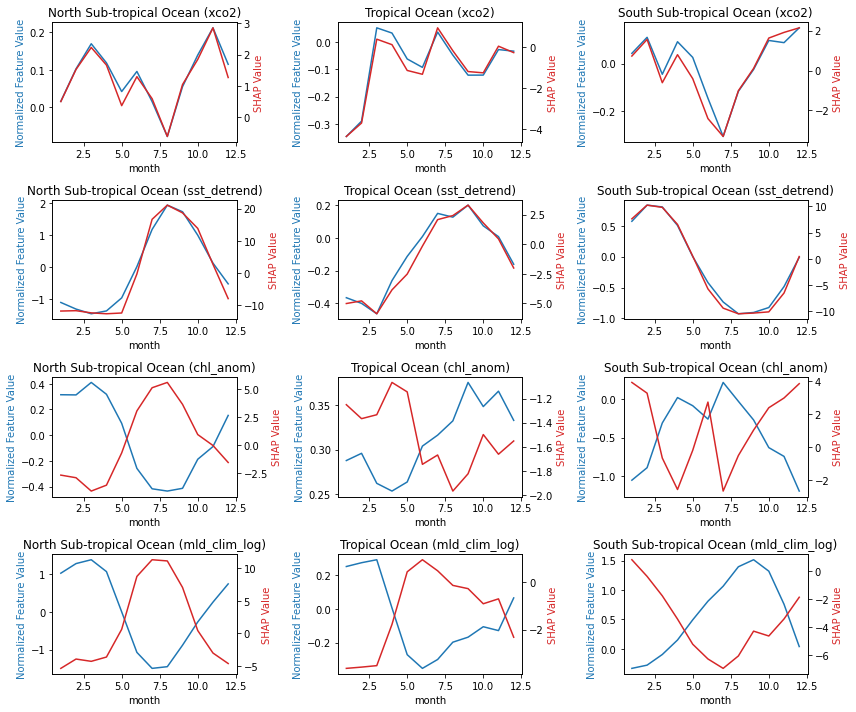

In [ ]:
#@title Examining seasonal feature values and their importance in different regions
X_test_grouper=X_test
X_test_grouper=(X_test_grouper-X_test_grouper.mean())/X_test_grouper.std() # Normalizing to bring all the features to same observable scale
X_test_grouper["Ocean Basin"] = shap_values_XGB["Ocean Basin"]
X_test_grouper["month"] = shap_values_XGB["month"]


month_grouper=X_test_grouper.groupby(["month","Ocean Basin"])[features_sel_2[0]].mean().reset_index()

for feature in features_sel_2[1:]:
  month_grouper[feature]=X_test_grouper.groupby(["month","Ocean Basin"])[feature].mean().reset_index()[feature]

month_grouper_shap=shap_values_XGB.groupby(["month","Ocean Basin"])[features_sel_2[0]].mean().reset_index()

for feature in features_sel_2[1:]:
  month_grouper_shap[feature]=shap_values_XGB.groupby(["month","Ocean Basin"])[feature].mean().reset_index()[feature]


# Plot mean feature values of top variables over month
n_top_features=5 # specify the number of features to be analysed
ocean_basins=["North Sub-tropical", "Tropical","South Sub-tropical"]
features=['xco2','sst_detrend','chl_anom','mld_clim_log']
month_grouper_top_var=month_grouper[list(top_variables)[0:n_top_features]+["month","Ocean Basin"]]
month_grouper_top_var=month_grouper_top_var.set_index("month")
month_grouper_top_var_shap=month_grouper_shap[list(top_variables)[0:n_top_features]+["month","Ocean Basin"]]
month_grouper_top_var_shap=month_grouper_top_var_shap.set_index("month")
nrows=4
ncols=3
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 10))
for row in range(nrows):
  for col in range(ncols):
    color = 'tab:blue'
    month_grouper_top_var.loc[month_grouper_top_var["Ocean Basin"]==ocean_basins[col], features[row]].plot.line(ax=axs[row,col], label=features[row],color=color)
    axs[row,col].set_ylabel('Normalized Feature Value', color=color)
    ax2 = axs[row,col].twinx()
    color = 'tab:red'
    month_grouper_top_var_shap.loc[month_grouper_top_var["Ocean Basin"]==ocean_basins[col], features[row]].plot.line(ax=ax2, label=features[row],color=color)
    ax2.set_ylabel('SHAP Value', color=color)
    axs[row,col].set_title(ocean_basins[col]+" Ocean "+'('+features[row]+')')
fig.tight_layout()
plt.show()



Above, we can identify some physically sensible trends. We see the strong seasonalities in temperature (and also mixed layer depth) in the north and south subtropics, as expected. We also notice that temperature and xCO2 variables have a direct relationship with how important it is in the model. I.e., the further a feature value deviates from average, the stronger of an impact it has on the model in the same direction. This makes sense for the variables xCO2 (dry air mixing ratio of atmospheric CO2) and SST since the higher mixing ratio would imply more pCO2 in the water, and in the subtropics, the pCO2 content tracks the temperature (Takahashi et al., 1993). 

On the other hand, we can see that the chlorophyll anomaly (chl_anom) and the mixed layer depth (mld_clim_log) feature values have almost an inverse relationship with the SHAP values. This makes intuitive sense as biological activity would reduce pCO2 in the water (by taking it in and capturing it as calcium carbonate) and a deeper mixed layer would mix the surface pCO2 deeper into the water, which reduces the amount at the surface.

An interesting takeaway is how the seasonalities become less apparent in the tropics, which again makes sense because there is simply less seasonality there. However, we see in the next plot below (from the starter code, linked [here](https://drive.google.com/file/d/1pBXCgl_SX0fCDOD8HW_g9Qt8YzAMXAtj/view?usp=sharing)) that this is a region where the model has some inaccuracies as well. Therefore, it is possible that the lack of seasonality accuracy in the tropics for the model arises simply due to a lack of seasonality of the features themselves.



Mean PCO2 correlation (evaluating seasonality capture):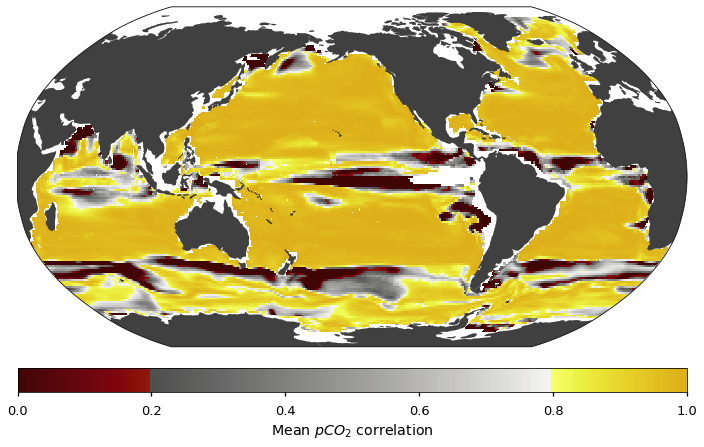

When we look at the importance of each feature when split into geographical regions (below) we get additional insights/physical validation. The importance of features change per region. Notably, temperature dominates in the north, while co2 mixing ratio is the most important feature in the south, followed by biological activity (chlorophyll anomaly) and temperature. In the tropics, co2 mixing ratio and temperature dominate, with biological activity being the least important out of our highlighted features. This also validates the physical nature of the system, as it is shown that biological activity has higher influence on pCO2 at higher latitudes (Takahashi et al., 1993). 


Tropical


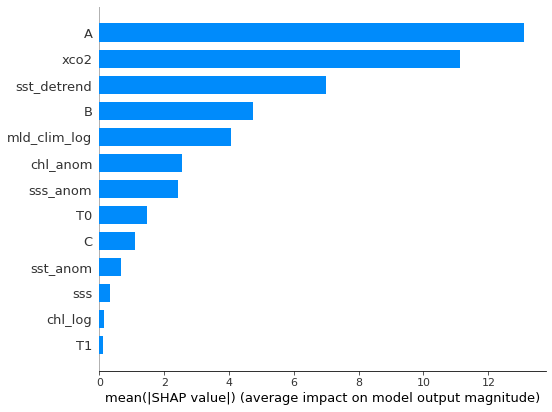





South Sub-tropical


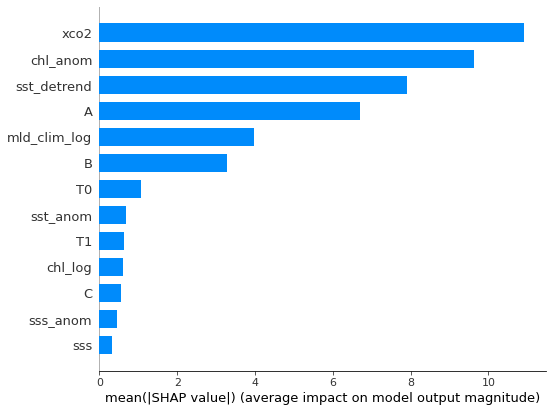





North Sub-tropical


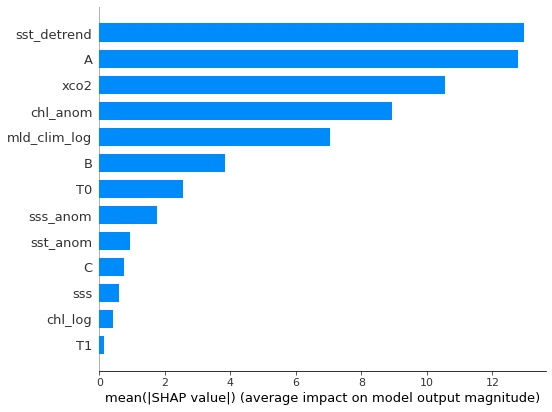

In [ ]:
#@title Shap values per region
X_test["Ocean Basin"]= shap_values_XGB["Ocean Basin"]
basins=["Tropical","South Sub-tropical","North Sub-tropical"]

for i,basin in enumerate(basins):
  print(basin)
  shap.summary_plot(shap_values_XGB[shap_values_XGB["Ocean Basin"]==basin][features_sel_2], X_test[features_sel_2], plot_type='bar',title="Average absolute shapley values: {}".format(basin))
  print("\n\n\n")
  plt.show()

We wanted to investifgate further the reason why seasonal discrepancy was showing biases in certain regions. We decided to focus on the areas where there is the least seasonal correlation : the tropics and the south. The tropics, as explained earlier, have probably less seasonal correlation  due to the physical system itself not showing high seasonality. 

Nevertheless, there seems to be a discrepancy in the south sub-tropical region as well. Interestingly, if we refer back to our seasonal plots, we see that one of the most important variables in the south is the chlorophyll anomaly. This variable shows a seasonality both in the north and south, but only the north shap values match that seasonality. This is visualized further if we look at spatial plots (code in seperate file [here](https://drive.google.com/file/d/1NNTbYHm9kWTxzsyTLgWfJGjh9KceuXwX/view?usp=sharing) since it crashes this one by filling up RAM). 


 
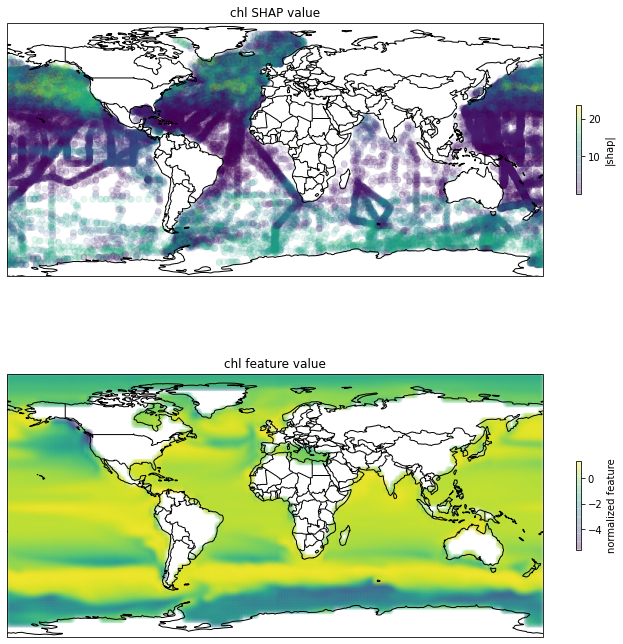



There is a clear band of high chl_anom (higher biological production) in the south. This band matches with the region where seaonality is not accurately reflected in our initial plot. Therefore, it is possible that the reconstruction fails to accomodate the seasonality of biological cycles in the southern ocean, and thus result in a failure to accurately capture seasonality of pco2 in its reconstruction.

# Discussion

We applied the same methodology to other members of the XGBoost model as well as random forest and LightGBM, and they have achieved similar results(ie: same top five features). This is available in the directory under "different models" or "new members". 

In conclusion, our SHAP value analysis has helped us identify the most important features to consider when reconstructing pCO2 values from the CanESM model. With this newly acquired information, we can prioritize the data that requires more precise modelling or to be collected for a better reconstruction of pCO2. Furthermore, the highlighted features validate the use of the Machine Learning models : they capture physical relationships between features that make sense. Finally, analyzing the trends in our features through the SHAP value method allows one to identify the potential failure points in the reconstruction. More specifically, we have showed a potential failure in capturing the importance of the biological activity in the southern ocean, which might explain the poor estimation of seasonality in pCO2. 



# References 
Gloege, L., McKinley, G. A., Landschützer, P., Fay, A. R., Frölicher, T. L., Fyfe, J. C., ... & Takano, Y. (2021). Quantifying errors in observationally based estimates of ocean carbon sink variability. Global Biogeochemical Cycles, 35(4), e2020GB006788.

Gloege, L., Yan, M., Zheng, T., & McKinley, G. A. (2022). Improved quantification of ocean carbon uptake by using machine learning to merge global models and pCO2 data. Journal of Advances in Modeling Earth Systems, 14(2), e2021MS002620.

Stamell, J., R.R. Rustagi, L. Gloege, and G.A. McKinley (2020) Strengths and weaknesses of three Machine Learning methods for pCO2 interpolation, Geoscientific Model Development Discussions doi:10.5194/gmd-2020-311

Takahashi, T., Olafsson, J., Goddard, J. G., Chipman, D. W., and Sutherland, S. C. (1993), Seasonal variation of CO2 and nutrients in the high-latitude surface oceans: A comparative study, Global Biogeochem. Cycles, 7( 4), 843– 878, doi:10.1029/93GB02263.